In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from collections import defaultdict
import os
from evaluate_flipflop import get_base_accuracy, get_digit_accuracy, get_relaxed_distance_accuracy, get_strict_distance_accuracy, get_per_dist_accuracy

In [2]:
llama_res = 'llama3.1_70B-instruct/sample_results'
olmo_res = 'OLMo_7B-instruct/sample_results'

length_10 = 'flipflop_10_spaced_results.jsonl'
length_18 = 'flipflop_18_spaced_results.jsonl'

In [3]:
def get_data(path):
    with open(path, 'r') as file:
        data = [json.loads(line) for line in file]
    return data

In [4]:
def get_of_length(length, path):
    data = get_data(path)

    flipflop_of_length = []
    for line in data:
        if len(line['flipflop']) == length:
            flipflop_of_length.append(line)

    return flipflop_of_length

In [5]:
llama_10_path = llama_res + '/' + length_10
llama_18_path = llama_res + '/' + length_18
olmo_10_path = olmo_res + '/' + length_10
olmo_18_path = olmo_res + '/' + length_18

In [6]:
llama_to_18 = get_data(llama_18_path)
olmo_to_18 = get_data(olmo_18_path)

In [7]:
flipflop_llama_4 = get_of_length(4, llama_10_path)
flipflop_llama_6 = get_of_length(6, llama_10_path)
flipflop_llama_8 = get_of_length(8, llama_10_path)
flipflop_llama_10 = get_of_length(10, llama_10_path)
flipflop_llama_12 = get_of_length(12, llama_18_path)
flipflop_llama_14 = get_of_length(14, llama_18_path)
flipflop_llama_16 = get_of_length(16, llama_18_path)
flipflop_llama_18 = get_of_length(18, llama_18_path)

llama_flipflops = {'4': flipflop_llama_4, '6': flipflop_llama_6, '8': flipflop_llama_8, '10': flipflop_llama_10, '12': flipflop_llama_12, 
                   '14': flipflop_llama_14, '16': flipflop_llama_16, '18': flipflop_llama_18}

In [8]:
flipflop_olmo_4 = get_of_length(4, olmo_10_path)
flipflop_olmo_6 = get_of_length(6, olmo_10_path)
flipflop_olmo_8 = get_of_length(8, olmo_10_path)
flipflop_olmo_10 = get_of_length(10, olmo_10_path)
flipflop_olmo_12 = get_of_length(12, olmo_18_path)
flipflop_olmo_14 = get_of_length(14, olmo_18_path)
flipflop_olmo_16 = get_of_length(16, olmo_18_path)
flipflop_olmo_18 = get_of_length(18, olmo_18_path)


olmo_flipflops = {'4': flipflop_olmo_4, '6': flipflop_olmo_6, '8': flipflop_olmo_8, '10': flipflop_olmo_10, '12': flipflop_olmo_12, 
                   '14': flipflop_olmo_14, '16': flipflop_olmo_16, '18': flipflop_olmo_18}

## Base accuracy for Llama Fliflops

Base accuracy for flipflop of length 4 is 1.0
Base accuracy for flipflop of length 6 is 1.0
Base accuracy for flipflop of length 8 is 1.0
Base accuracy for flipflop of length 10 is 0.9864864864864865
Base accuracy for flipflop of length 12 is 0.9738461538461538
Base accuracy for flipflop of length 14 is 0.9497206703910615
Base accuracy for flipflop of length 16 is 0.8772360297609625
Base accuracy for flipflop of length 18 is 0.8321436257981204


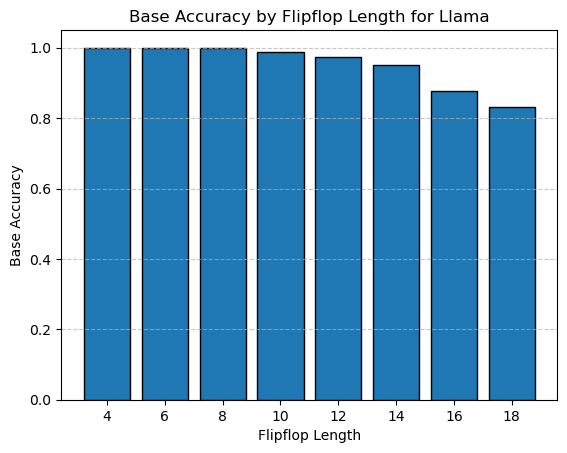

In [9]:
lengths = []
base_accuracies = []
for length in llama_flipflops.keys():
    acc = get_base_accuracy(llama_flipflops[length])
    print(f"Base accuracy for flipflop of length {length} is {acc}")
    lengths.append(length)
    base_accuracies.append(acc)

plt.bar(lengths, base_accuracies, width=0.8, align='center', edgecolor='black')
plt.xlabel("Flipflop Length")
plt.ylabel("Base Accuracy")
plt.title("Base Accuracy by Flipflop Length for Llama")
plt.xticks(lengths) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Base accuracy for OLMo Flipflops

Base accuracy for flipflop of length 4 is 0.5
Base accuracy for flipflop of length 6 is 0.5
Base accuracy for flipflop of length 8 is 0.5
Base accuracy for flipflop of length 10 is 0.5202702702702703
Base accuracy for flipflop of length 12 is 0.5461538461538461
Base accuracy for flipflop of length 14 is 0.5286312849162011
Base accuracy for flipflop of length 16 is 0.5117144214025645
Base accuracy for flipflop of length 18 is 0.5066898629743884


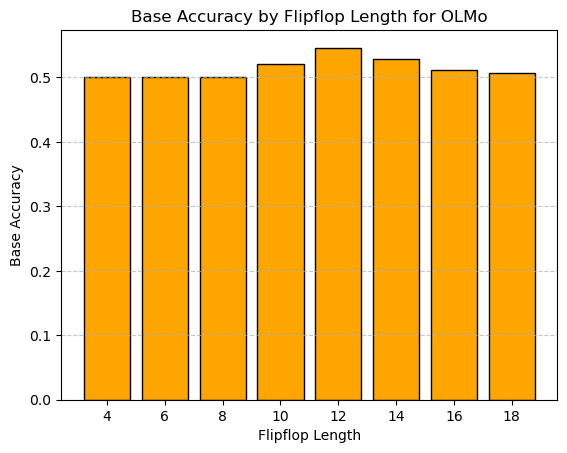

In [10]:
lengths = []
base_accuracies = []
for length in olmo_flipflops.keys():
    acc = get_base_accuracy(olmo_flipflops[length])
    print(f"Base accuracy for flipflop of length {length} is {acc}")
    lengths.append(length)
    base_accuracies.append(acc)

plt.bar(lengths, base_accuracies, width=0.8, align='center', edgecolor='black', color='orange')
plt.xlabel("Flipflop Length")
plt.ylabel("Base Accuracy")
plt.title("Base Accuracy by Flipflop Length for OLMo")
plt.xticks(lengths) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Per digit accuracy for Llama Flipflops - digit 0

In [11]:
length_0 = []
acc_0 = []
for length in llama_flipflops.keys():
    acc = get_digit_accuracy(llama_flipflops[length], 0)
    print(f"Digit accuracy for flipflop of length {length} is {acc}")
    acc_0.append(acc)
    length_0.append(0)

Digit accuracy for flipflop of length 4 is 1.0
Digit accuracy for flipflop of length 6 is 1.0
Digit accuracy for flipflop of length 8 is 1.0
Digit accuracy for flipflop of length 10 is 0.9864864864864865
Digit accuracy for flipflop of length 12 is 0.9661538461538461
Digit accuracy for flipflop of length 14 is 0.9378491620111732
Digit accuracy for flipflop of length 16 is 0.8643343359189488
Digit accuracy for flipflop of length 18 is 0.8052586268742378


## Per digit accuracy for Llama Flipflops - digit 1

In [12]:
length_1 = []
acc_1 = []
for length in llama_flipflops.keys():
    acc = get_digit_accuracy(llama_flipflops[length], 1)
    print(f"Digit accuracy for flipflop of length {length} is {acc}")
    acc_1.append(acc)
    length_1.append(length)

Digit accuracy for flipflop of length 4 is 1.0
Digit accuracy for flipflop of length 6 is 1.0
Digit accuracy for flipflop of length 8 is 1.0
Digit accuracy for flipflop of length 10 is 0.9864864864864865
Digit accuracy for flipflop of length 12 is 0.9815384615384616
Digit accuracy for flipflop of length 14 is 0.9615921787709497
Digit accuracy for flipflop of length 16 is 0.890137723602976
Digit accuracy for flipflop of length 18 is 0.859028624722003


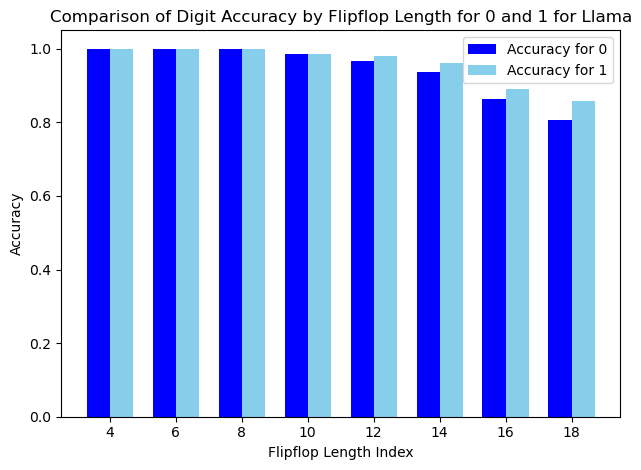

In [13]:
bar_width = 0.35

indices = np.arange(len(length_1))

plt.bar(indices - bar_width / 2, acc_0, bar_width, label="Accuracy for 0", color='blue')
plt.bar(indices + bar_width / 2, acc_1, bar_width, label="Accuracy for 1", color='skyblue')

plt.xlabel("Flipflop Length Index")
plt.ylabel("Accuracy")
plt.title("Comparison of Digit Accuracy by Flipflop Length for 0 and 1 for Llama")
plt.xticks(indices, length_1) 
plt.legend()

plt.tight_layout()
plt.show()

## Per digit accuracy for OLMo Flipflops - digit 0

In [14]:
length_0 = []
acc_0 = []
for length in olmo_flipflops.keys():
    acc = get_digit_accuracy(olmo_flipflops[length], 0)
    print(f"Digit accuracy for flipflop of length {length} is {acc}")
    acc_0.append(acc)
    length_0.append(0)

Digit accuracy for flipflop of length 4 is 1.0
Digit accuracy for flipflop of length 6 is 1.0
Digit accuracy for flipflop of length 8 is 1.0
Digit accuracy for flipflop of length 10 is 1.0
Digit accuracy for flipflop of length 12 is 1.0
Digit accuracy for flipflop of length 14 is 0.9979050279329609
Digit accuracy for flipflop of length 16 is 0.9987335760645876
Digit accuracy for flipflop of length 18 is 0.9969868713681039


## Per digit accuracy for OLMo Flipflops - digit 1

In [15]:
length_1 = []
acc_1 = []
for length in olmo_flipflops.keys():
    acc = get_digit_accuracy(olmo_flipflops[length], 1)
    print(f"Digit accuracy for flipflop of length {length} is {acc}")
    acc_1.append(acc)
    length_1.append(length)

Digit accuracy for flipflop of length 4 is 0.0
Digit accuracy for flipflop of length 6 is 0.0
Digit accuracy for flipflop of length 8 is 0.0
Digit accuracy for flipflop of length 10 is 0.04054054054054054
Digit accuracy for flipflop of length 12 is 0.09230769230769231
Digit accuracy for flipflop of length 14 is 0.05935754189944134
Digit accuracy for flipflop of length 16 is 0.024695266740541396
Digit accuracy for flipflop of length 18 is 0.01639285458067293


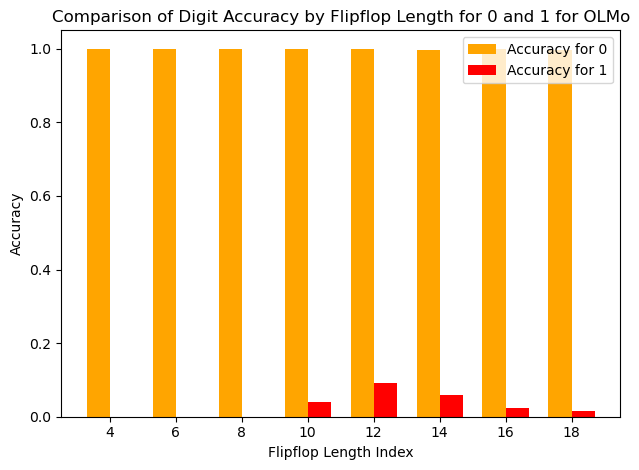

In [16]:
bar_width = 0.35

indices = np.arange(len(length_1))

plt.bar(indices - bar_width / 2, acc_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, acc_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Flipflop Length Index")
plt.ylabel("Accuracy")
plt.title("Comparison of Digit Accuracy by Flipflop Length for 0 and 1 for OLMo")
plt.xticks(indices, length_1) 
plt.legend()

plt.tight_layout()
plt.show()

## Per distance to last write for Llama Flipflops

For distance 4 the accuracy is 0.844037094817126
For distance 6 the accuracy is 0.8236307927996936
For distance 8 the accuracy is 0.8515065913370998
For distance 10 the accuracy is 0.8483709273182958
For distance 12 the accuracy is 0.8592592592592593
For distance 14 the accuracy is 0.8733098177542622
For distance 16 the accuracy is 0.869684499314129
For distance 18 the accuracy is 0.8737997256515775


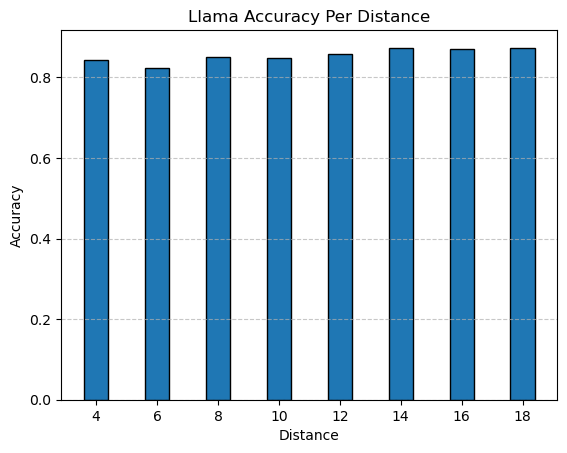

In [17]:
llama_per_distance = get_per_dist_accuracy(llama_to_18)
for dist, acc in llama_per_distance.items():
    print(f"For distance {dist} the accuracy is {acc}")

distances = list(llama_per_distance.keys())
accuracies = list(llama_per_distance.values())

plt.bar(distances, accuracies, width=0.8, align='center', edgecolor='black')
plt.xlabel("Distance")
plt.ylabel("Accuracy")
plt.title("Llama Accuracy Per Distance")
plt.xticks(distances) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Per distance to last write for OLMo Flipflops

For distance 4 the accuracy is 0.5172473565609291
For distance 6 the accuracy is 0.5106600280863015
For distance 8 the accuracy is 0.5044256120527307
For distance 10 the accuracy is 0.5030632135895294
For distance 12 the accuracy is 0.5008230452674897
For distance 14 the accuracy is 0.4997060552616108
For distance 16 the accuracy is 0.4996570644718793
For distance 18 the accuracy is 0.5


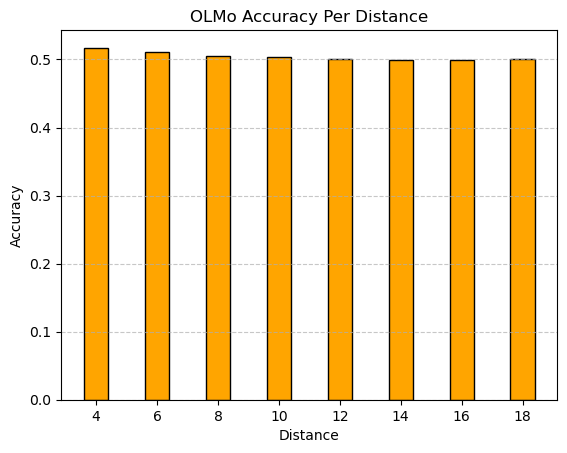

In [18]:
olmo_per_distance = get_per_dist_accuracy(olmo_to_18)
for dist, acc in olmo_per_distance.items():
    print(f"For distance {dist} the accuracy is {acc}")

distances_olmo = list(olmo_per_distance.keys())
accuracies_olmo = list(olmo_per_distance.values())

plt.bar(distances_olmo, accuracies_olmo, width=0.8, align='center', edgecolor='black', color='orange')
plt.xlabel("Distance")
plt.ylabel("Accuracy")
plt.title("OLMo Accuracy Per Distance")
plt.xticks(distances_olmo)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Let's see what is happening with OLMo and digit "1"

In [19]:
ones = []
count_w0 = 0
for ans in olmo_flipflops['18']:
    if ans['last_valid_token'] == 1 and ans['answer'] != ans['last_valid_token']:
        ones.append(ans)
        if ans['flipflop'][1] == '0':
            count_w0 += 1

print(len(ones))
print(count_w0)

27421
10038


In [20]:
pattern = r"Therefore.*?(\d)"

In [21]:
count = 0
count_w0 = 0
for ans in ones:
    matches = re.findall(pattern, ans['full_answer'])
    if '1' in matches:
        count += 1
        #print(ans['full_answer'])
        if ans['flipflop'][1] == '0':
                count_w0 += 1

print(count) # Only 2208/27421 maybe reasoning correct, final output isn't
print(count_w0)

2208
152


# Llama and OLMo: Longer strings, sparsity and distance to last write

## Sparse Llama results - w and r probability of 0.1

In [45]:
llama_path = "llama3.1_70B-instruct/sparse/s4"

all_data_llama = []

for file_name in os.listdir(llama_path):
    if file_name.endswith(".jsonl"):
        file_path = os.path.join(llama_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            one_sample_data = []
            for line in file:
                one_sample = json.loads(line)
                one_sample_data.append(one_sample)
            all_data_llama.append(one_sample_data)

print(f"Loaded {len(all_data_llama)} entries from {llama_path}.")

# Assert everything loaded correctly
for result in all_data_llama:
    length = len(result[0]['flipflop'])
    for response in result:
        assert len(response['flipflop']) == length


Loaded 50 entries from llama3.1_70B/sparse/s4.


Base accuracy for sparse length 10 is 0.98
Base accuracy for sparse length 20 is 0.99
Base accuracy for sparse length 30 is 1.0
Base accuracy for sparse length 40 is 0.99
Base accuracy for sparse length 50 is 0.99
Base accuracy for sparse length 60 is 0.99
Base accuracy for sparse length 70 is 0.99
Base accuracy for sparse length 80 is 0.99
Base accuracy for sparse length 90 is 0.96
Base accuracy for sparse length 100 is 0.99
Base accuracy for sparse length 110 is 0.92
Base accuracy for sparse length 120 is 0.94
Base accuracy for sparse length 130 is 0.85
Base accuracy for sparse length 140 is 0.63
Base accuracy for sparse length 150 is 0.78
Base accuracy for sparse length 160 is 0.63
Base accuracy for sparse length 170 is 0.73
Base accuracy for sparse length 180 is 0.47
Base accuracy for sparse length 190 is 0.41
Base accuracy for sparse length 200 is 0.19
Base accuracy for sparse length 210 is 0.02
Base accuracy for sparse length 220 is 0.0
Base accuracy for sparse length 230 is 0.01

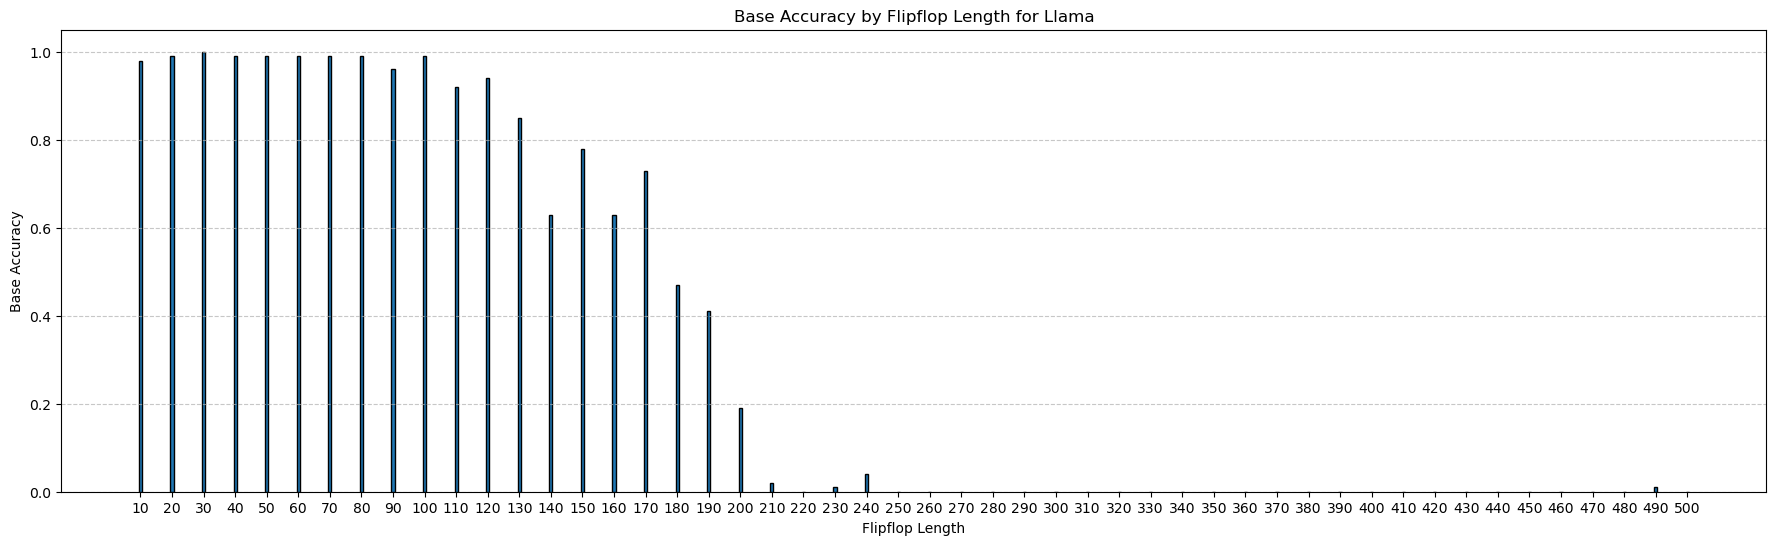

In [46]:
# Get base accuracy for each sparse length

lengths = []
base_accuracies = []
acc_by_length = {}
for result in all_data_llama:
    acc = get_base_accuracy(result)
    length = len(result[0]['flipflop'])
    lengths.append(length)
    base_accuracies.append(acc)
    acc_by_length[length] = acc

# Reverse sort and display results
sorted_acc = dict(sorted(acc_by_length.items(), key=lambda item: item[0], reverse=False))
for length in sorted_acc.keys():
    print(f'Base accuracy for sparse length {length} is {sorted_acc[length]}')

plt.figure(figsize=(22, 6))
plt.bar(lengths, base_accuracies, width=1, align='center', edgecolor='black')
plt.xlabel("Flipflop Length")
plt.ylabel("Base Accuracy")
plt.title("Base Accuracy by Flipflop Length for Llama")
plt.xticks(lengths) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [24]:
length_1 = []
acc_1 = []
acc_by_length = {}
    
for result in all_data_llama:
    acc = get_digit_accuracy(result, 1)
    length = len(result[0]['flipflop'])
    acc_by_length[length] = acc
    acc_1.append(acc)
    length_1.append(length)


sorted_acc = dict(sorted(acc_by_length.items(), key=lambda item: item[0], reverse=False))
for length in sorted_acc.keys():
    print(f"Digit accuracy for flipflop of length {length} is {sorted_acc[length]}")

Digit accuracy for flipflop of length 10 is 1.0
Digit accuracy for flipflop of length 20 is 1.0
Digit accuracy for flipflop of length 30 is 1.0
Digit accuracy for flipflop of length 40 is 1.0
Digit accuracy for flipflop of length 50 is 1.0
Digit accuracy for flipflop of length 60 is 1.0
Digit accuracy for flipflop of length 70 is 1.0
Digit accuracy for flipflop of length 80 is 1.0
Digit accuracy for flipflop of length 90 is 1.0
Digit accuracy for flipflop of length 100 is 0.975609756097561
Digit accuracy for flipflop of length 110 is 0.9387755102040817
Digit accuracy for flipflop of length 120 is 0.9245283018867925
Digit accuracy for flipflop of length 130 is 0.8409090909090909
Digit accuracy for flipflop of length 140 is 0.7
Digit accuracy for flipflop of length 150 is 0.7586206896551724
Digit accuracy for flipflop of length 160 is 0.782608695652174
Digit accuracy for flipflop of length 170 is 0.7017543859649122
Digit accuracy for flipflop of length 180 is 0.40425531914893614
Digit ac

In [25]:
length_0 = []
acc_0 = []
acc_by_length = {}
    
for result in all_data_llama:
    acc = get_digit_accuracy(result, 0)
    length = len(result[0]['flipflop'])
    acc_by_length[length] = acc
    acc_0.append(acc)
    length_0.append(length)


sorted_acc = dict(sorted(acc_by_length.items(), key=lambda item: item[0], reverse=False))
for length in sorted_acc.keys():
    print(f"Digit accuracy for flipflop of length {length} is {sorted_acc[length]}")

Digit accuracy for flipflop of length 10 is 1.0
Digit accuracy for flipflop of length 20 is 1.0
Digit accuracy for flipflop of length 30 is 1.0
Digit accuracy for flipflop of length 40 is 0.9583333333333334
Digit accuracy for flipflop of length 50 is 1.0
Digit accuracy for flipflop of length 60 is 0.9821428571428571
Digit accuracy for flipflop of length 70 is 1.0
Digit accuracy for flipflop of length 80 is 0.9791666666666666
Digit accuracy for flipflop of length 90 is 0.9814814814814815
Digit accuracy for flipflop of length 100 is 0.9661016949152542
Digit accuracy for flipflop of length 110 is 0.9215686274509803
Digit accuracy for flipflop of length 120 is 0.8085106382978723
Digit accuracy for flipflop of length 130 is 0.8214285714285714
Digit accuracy for flipflop of length 140 is 0.64
Digit accuracy for flipflop of length 150 is 0.7380952380952381
Digit accuracy for flipflop of length 160 is 0.7037037037037037
Digit accuracy for flipflop of length 170 is 0.6976744186046512
Digit accu

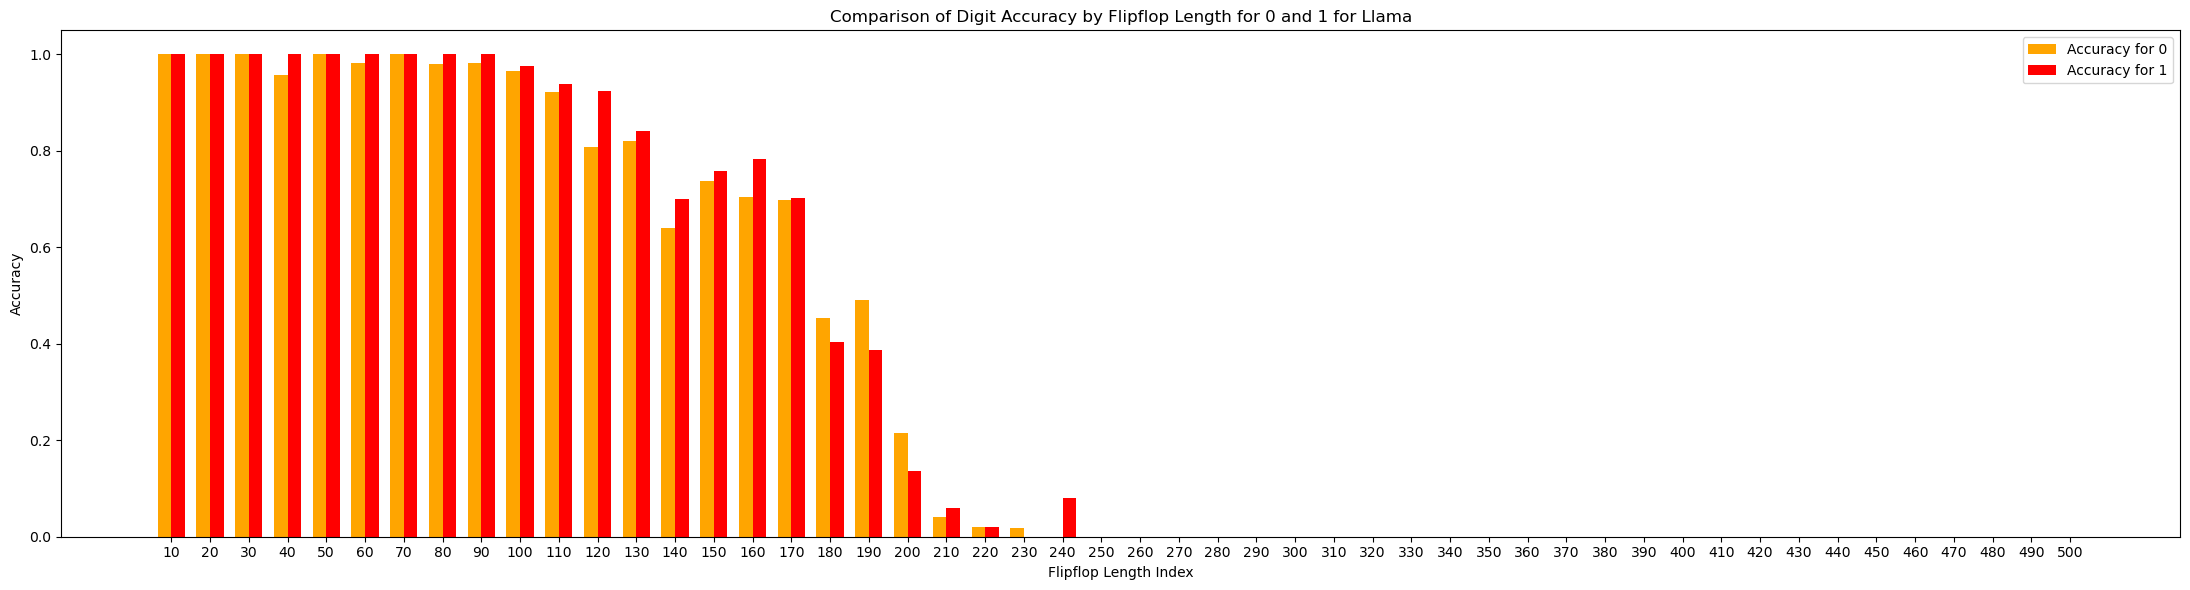

In [26]:
sorted_data = sorted(zip(length_1, acc_0, acc_1), key=lambda x: x[0])
sorted_lengths, sorted_acc_0, sorted_acc_1 = zip(*sorted_data)

# Plotting
bar_width = 0.35
indices = np.arange(len(sorted_lengths))

plt.figure(figsize=(22, 6))
plt.bar(indices - bar_width / 2, sorted_acc_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, sorted_acc_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Flipflop Length Index")
plt.ylabel("Accuracy")
plt.title("Comparison of Digit Accuracy by Flipflop Length for 0 and 1 for Llama")
plt.xticks(indices, sorted_lengths) 
plt.legend()

plt.tight_layout()
plt.show()

# Sparse OLMo results - w and r probability of 0.1

In [27]:
olmo_path = "OLMo_7B-instruct/sparse/s1"

all_data_olmo = []

for file_name in os.listdir(olmo_path):
    if file_name.endswith(".jsonl"):
        file_path = os.path.join(olmo_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            one_sample_data = []
            for line in file:
                one_sample = json.loads(line)
                one_sample_data.append(one_sample)
            all_data_olmo.append(one_sample_data)

print(f"Loaded {len(all_data_olmo)} entries from {olmo_path}.")

# Assert everything loaded correctly
for result in all_data_olmo:
    length = len(result[0]['flipflop'])
    for response in result:
        assert len(response['flipflop']) == length


Loaded 50 entries from OLMo_7B/sparse/s1.


Base accuracy for sparse length 10 is 0.6
Base accuracy for sparse length 20 is 0.62
Base accuracy for sparse length 30 is 0.52
Base accuracy for sparse length 40 is 0.48
Base accuracy for sparse length 50 is 0.58
Base accuracy for sparse length 60 is 0.64
Base accuracy for sparse length 70 is 0.48
Base accuracy for sparse length 80 is 0.51
Base accuracy for sparse length 90 is 0.43
Base accuracy for sparse length 100 is 0.41
Base accuracy for sparse length 110 is 0.57
Base accuracy for sparse length 120 is 0.6
Base accuracy for sparse length 130 is 0.58
Base accuracy for sparse length 140 is 0.55
Base accuracy for sparse length 150 is 0.35
Base accuracy for sparse length 160 is 0.49
Base accuracy for sparse length 170 is 0.48
Base accuracy for sparse length 180 is 0.56
Base accuracy for sparse length 190 is 0.5
Base accuracy for sparse length 200 is 0.49
Base accuracy for sparse length 210 is 0.49
Base accuracy for sparse length 220 is 0.46
Base accuracy for sparse length 230 is 0.53


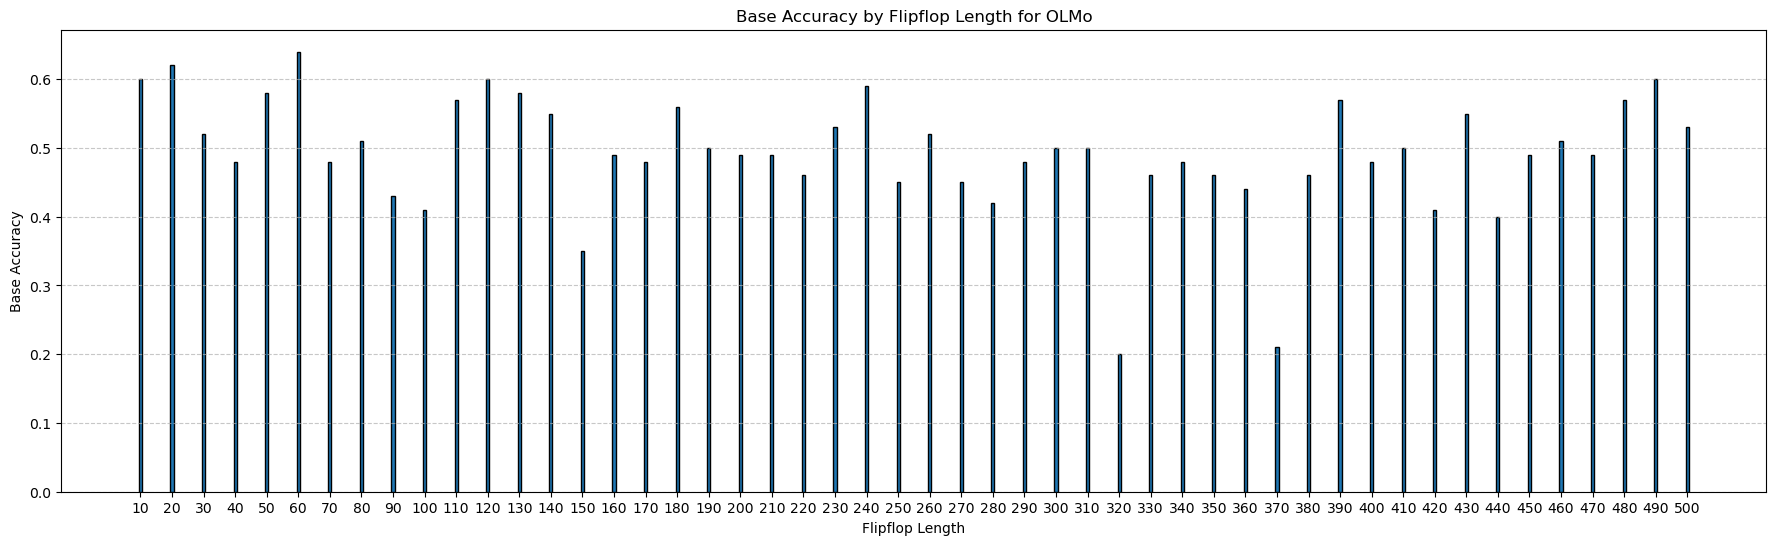

In [28]:
# Get base accuracy for each sparse length

lengths = []
base_accuracies = []
acc_by_length = {}
for result in all_data_olmo:
    acc = get_base_accuracy(result)
    length = len(result[0]['flipflop'])
    lengths.append(length)
    base_accuracies.append(acc)
    acc_by_length[length] = acc

# Reverse sort and display results
sorted_acc = dict(sorted(acc_by_length.items(), key=lambda item: item[0], reverse=False))
for length in sorted_acc.keys():
    print(f'Base accuracy for sparse length {length} is {sorted_acc[length]}')

plt.figure(figsize=(22, 6))
plt.bar(lengths, base_accuracies, width=1, align='center', edgecolor='black')
plt.xlabel("Flipflop Length")
plt.ylabel("Base Accuracy")
plt.title("Base Accuracy by Flipflop Length for OLMo")
plt.xticks(lengths) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [29]:
length_1 = []
acc_1 = []
acc_by_length = {}
    
for result in all_data_olmo:
    acc = get_digit_accuracy(result, 1)
    length = len(result[0]['flipflop'])
    acc_by_length[length] = acc
    acc_1.append(acc)
    length_1.append(length)


sorted_acc = dict(sorted(acc_by_length.items(), key=lambda item: item[0], reverse=False))
for length in sorted_acc.keys():
    print(f"Digit accuracy for flipflop of length {length} is {sorted_acc[length]}")

Digit accuracy for flipflop of length 10 is 0.19148936170212766
Digit accuracy for flipflop of length 20 is 0.05
Digit accuracy for flipflop of length 30 is 0.04
Digit accuracy for flipflop of length 40 is 0.057692307692307696
Digit accuracy for flipflop of length 50 is 0.3333333333333333
Digit accuracy for flipflop of length 60 is 0.5
Digit accuracy for flipflop of length 70 is 0.3404255319148936
Digit accuracy for flipflop of length 80 is 0.3269230769230769
Digit accuracy for flipflop of length 90 is 0.45652173913043476
Digit accuracy for flipflop of length 100 is 0.36585365853658536
Digit accuracy for flipflop of length 110 is 0.5510204081632653
Digit accuracy for flipflop of length 120 is 0.4716981132075472
Digit accuracy for flipflop of length 130 is 0.5
Digit accuracy for flipflop of length 140 is 0.3
Digit accuracy for flipflop of length 150 is 0.3103448275862069
Digit accuracy for flipflop of length 160 is 0.3695652173913043
Digit accuracy for flipflop of length 170 is 0.736842

In [30]:
length_0 = []
acc_0 = []
acc_by_length = {}
    
for result in all_data_olmo:
    acc = get_digit_accuracy(result, 0)
    length = len(result[0]['flipflop'])
    acc_by_length[length] = acc
    acc_0.append(acc)
    length_0.append(length)


sorted_acc = dict(sorted(acc_by_length.items(), key=lambda item: item[0], reverse=False))
for length in sorted_acc.keys():
    print(f"Digit accuracy for flipflop of length {length} is {sorted_acc[length]}")

Digit accuracy for flipflop of length 10 is 0.9622641509433962
Digit accuracy for flipflop of length 20 is 1.0
Digit accuracy for flipflop of length 30 is 1.0
Digit accuracy for flipflop of length 40 is 0.9375
Digit accuracy for flipflop of length 50 is 0.8076923076923077
Digit accuracy for flipflop of length 60 is 0.75
Digit accuracy for flipflop of length 70 is 0.6037735849056604
Digit accuracy for flipflop of length 80 is 0.7083333333333334
Digit accuracy for flipflop of length 90 is 0.4074074074074074
Digit accuracy for flipflop of length 100 is 0.4406779661016949
Digit accuracy for flipflop of length 110 is 0.5882352941176471
Digit accuracy for flipflop of length 120 is 0.7446808510638298
Digit accuracy for flipflop of length 130 is 0.6428571428571429
Digit accuracy for flipflop of length 140 is 0.8
Digit accuracy for flipflop of length 150 is 0.40476190476190477
Digit accuracy for flipflop of length 160 is 0.5925925925925926
Digit accuracy for flipflop of length 170 is 0.13953488

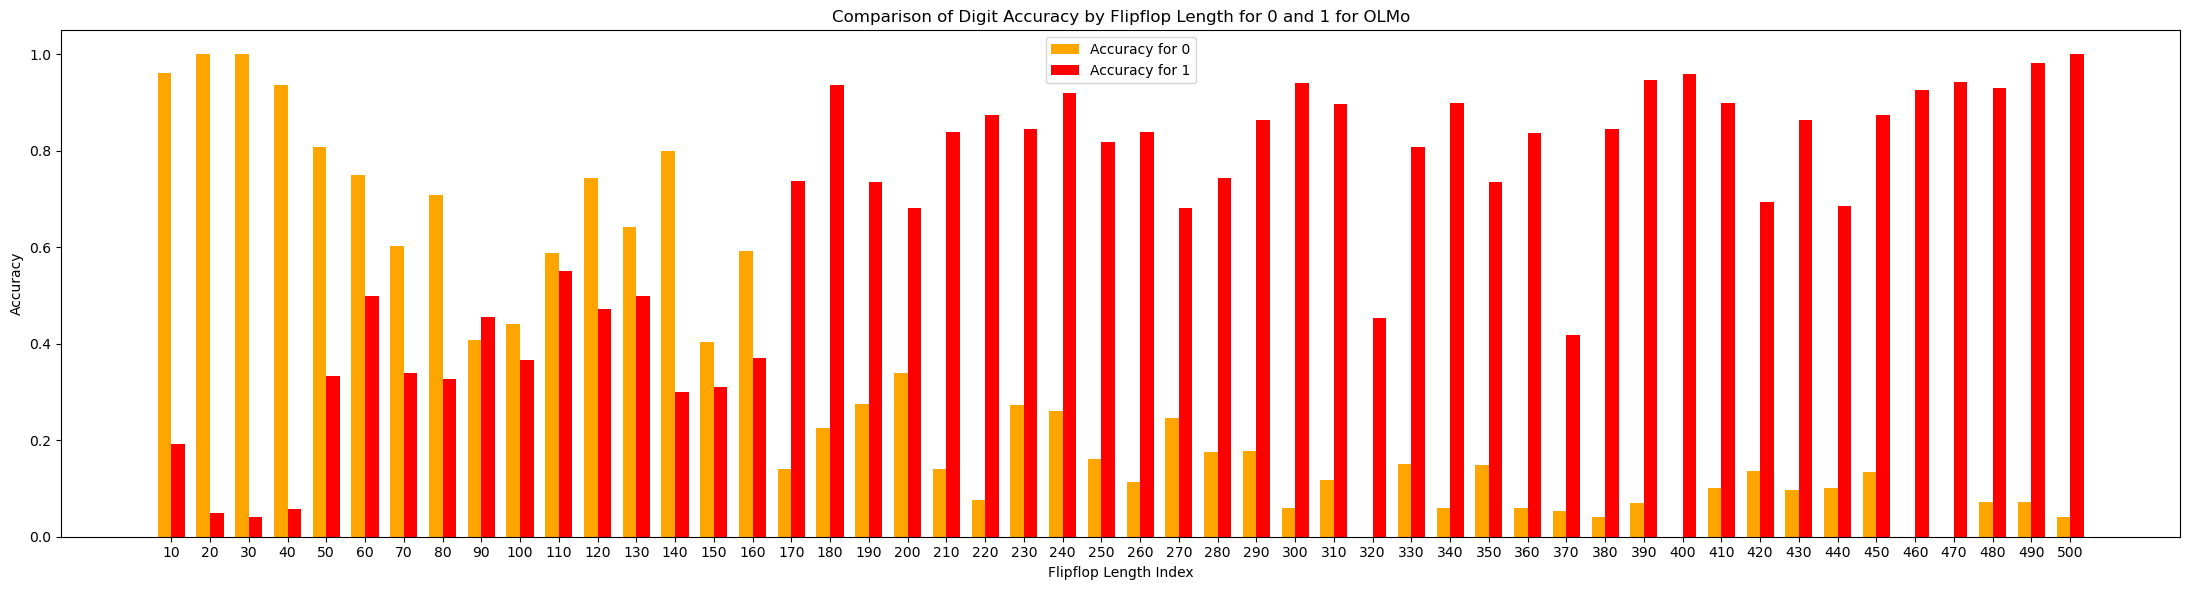

In [31]:
sorted_data = sorted(zip(length_1, acc_0, acc_1), key=lambda x: x[0])
sorted_lengths, sorted_acc_0, sorted_acc_1 = zip(*sorted_data)

# Plotting
bar_width = 0.35
indices = np.arange(len(sorted_lengths))

plt.figure(figsize=(22, 6))
plt.bar(indices - bar_width / 2, sorted_acc_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, sorted_acc_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Flipflop Length Index")
plt.ylabel("Accuracy")
plt.title("Comparison of Digit Accuracy by Flipflop Length for 0 and 1 for OLMo")
plt.xticks(indices, sorted_lengths) 
plt.legend()

plt.tight_layout()
plt.show()

# Llama and OLMo per distance to last write

## Distance Llama results

In [32]:
llama_path = "llama3.1_70B-instruct/distance/s1"

all_data_llama = []

for file_name in os.listdir(llama_path):
    if file_name.endswith(".jsonl"):
        file_path = os.path.join(llama_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            one_sample_data = []
            for line in file:
                one_sample = json.loads(line)
                one_sample_data.append(one_sample)
            all_data_llama.append(one_sample_data)

print(f"Loaded {len(all_data_llama)} entries from {llama_path}.")

# Assert everything loaded correctly
for result in all_data_llama:
    length = len(result[0]['flipflop'])
    for response in result:
        assert len(response['flipflop']) == length


Loaded 58 entries from llama3.1_70B/distance/s1.


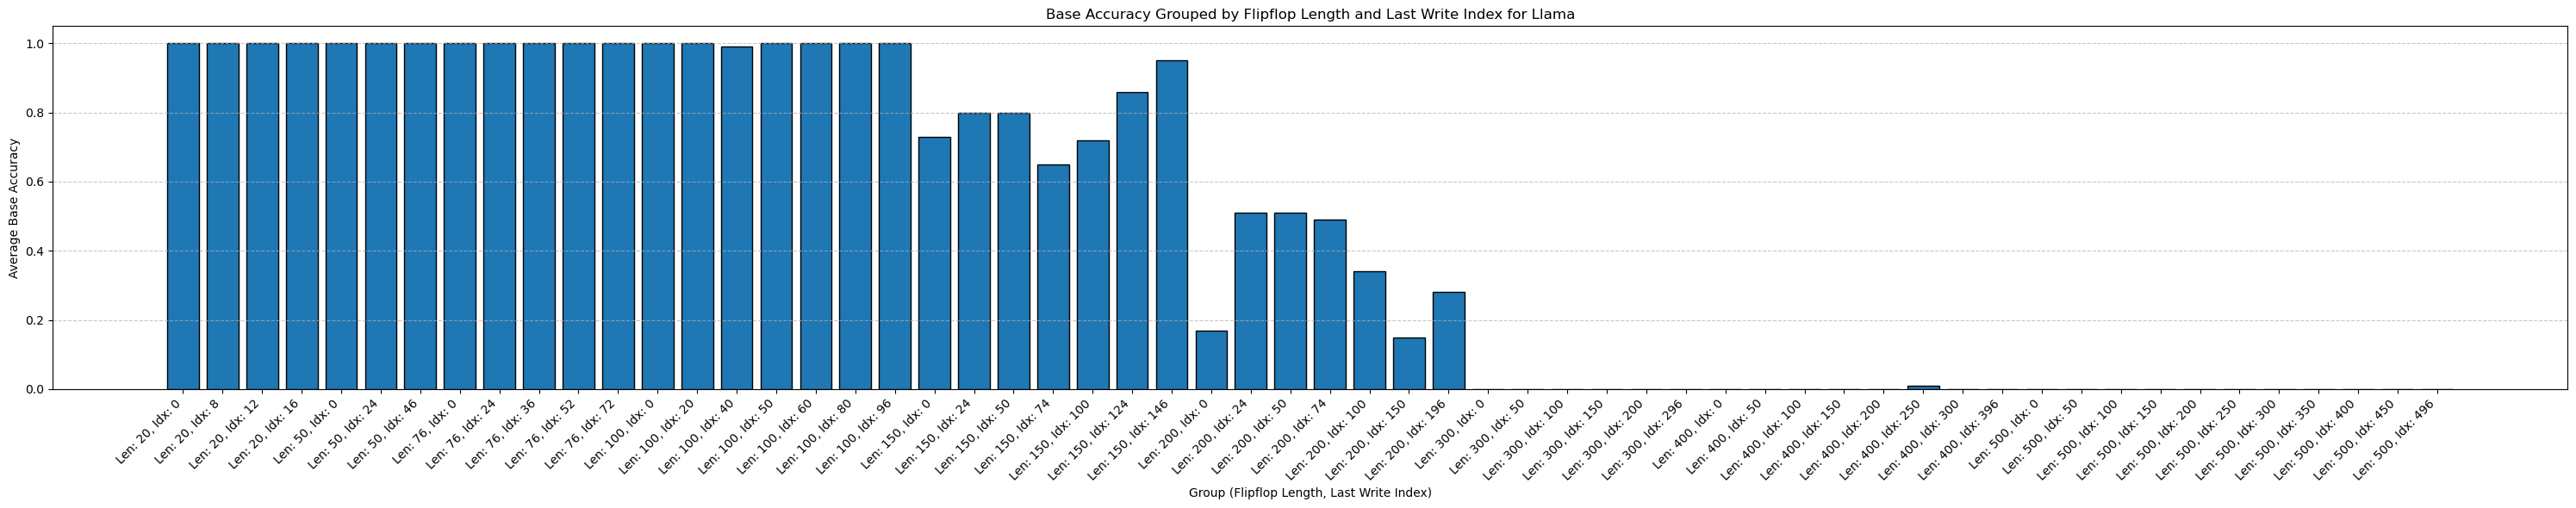

In [33]:
grouped_accuracies = defaultdict(list)

for result in all_data_llama:
    acc = get_base_accuracy(result)
    length = len(result[0]['flipflop'])
    idx = result[0]['last_write_index']
    grouped_accuracies[(length, idx)].append(acc)

# Aggregate and sort data
grouped_results = {}
for (length, idx), accuracies in grouped_accuracies.items():
    avg_acc = sum(accuracies) / len(accuracies)  # Average accuracy for the group
    grouped_results[(length, idx)] = avg_acc

# Sort by length and last_write_index
sorted_grouped_results = dict(sorted(grouped_results.items(), key=lambda x: (x[0][0], x[0][1])))

# Prepare data for plotting
x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted_grouped_results.keys()]
accuracies = list(sorted_grouped_results.values())

# Plot
plt.figure(figsize=(30, 6))
plt.bar(x_labels, accuracies, width=0.8, align='center', edgecolor='black')
plt.xlabel("Group (Flipflop Length, Last Write Index)")
plt.ylabel("Average Base Accuracy")
plt.title("Base Accuracy Grouped by Flipflop Length and Last Write Index for Llama")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [34]:
grouped_digit_accuracies_0 = defaultdict(list)

for result in all_data_llama:
    length = len(result[0]['flipflop'])
    dist = result[0]['last_write_index']
    acc = get_digit_accuracy(result, 0)  # Replace 0 with desired digit if needed
    grouped_digit_accuracies_0[(length, dist)].append(acc)

# Aggregate and sort data
grouped_results_0 = {}
for (length, dist), accuracies in grouped_digit_accuracies_0.items():
    avg_acc = sum(accuracies) / len(accuracies)  # Average accuracy for the group
    grouped_results_0[(length, dist)] = avg_acc

# Sort by length and last_write_index
sorted_grouped_results_0 = dict(sorted(grouped_results_0.items(), key=lambda x: (x[0][0], x[0][1])))

# Display results
for (length, dist), avg_acc in sorted_grouped_results_0.items():
    print(f"Digit accuracy for flipflop with length {length} and last write idx {dist} is {avg_acc}")


Digit accuracy for flipflop with length 20 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 20 and last write idx 8 is 1.0
Digit accuracy for flipflop with length 20 and last write idx 12 is 1.0
Digit accuracy for flipflop with length 20 and last write idx 16 is 1.0
Digit accuracy for flipflop with length 50 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 50 and last write idx 24 is 1.0
Digit accuracy for flipflop with length 50 and last write idx 46 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 24 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 36 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 52 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 72 is 1.0
Digit accuracy for flipflop with length 100 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 100 and last write idx 20 is

Digit accuracy for flipflop with length 20 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 20 and last write idx 8 is 1.0
Digit accuracy for flipflop with length 20 and last write idx 12 is 1.0
Digit accuracy for flipflop with length 20 and last write idx 16 is 1.0
Digit accuracy for flipflop with length 50 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 50 and last write idx 24 is 1.0
Digit accuracy for flipflop with length 50 and last write idx 46 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 24 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 36 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 52 is 1.0
Digit accuracy for flipflop with length 76 and last write idx 72 is 1.0
Digit accuracy for flipflop with length 100 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 100 and last write idx 20 is

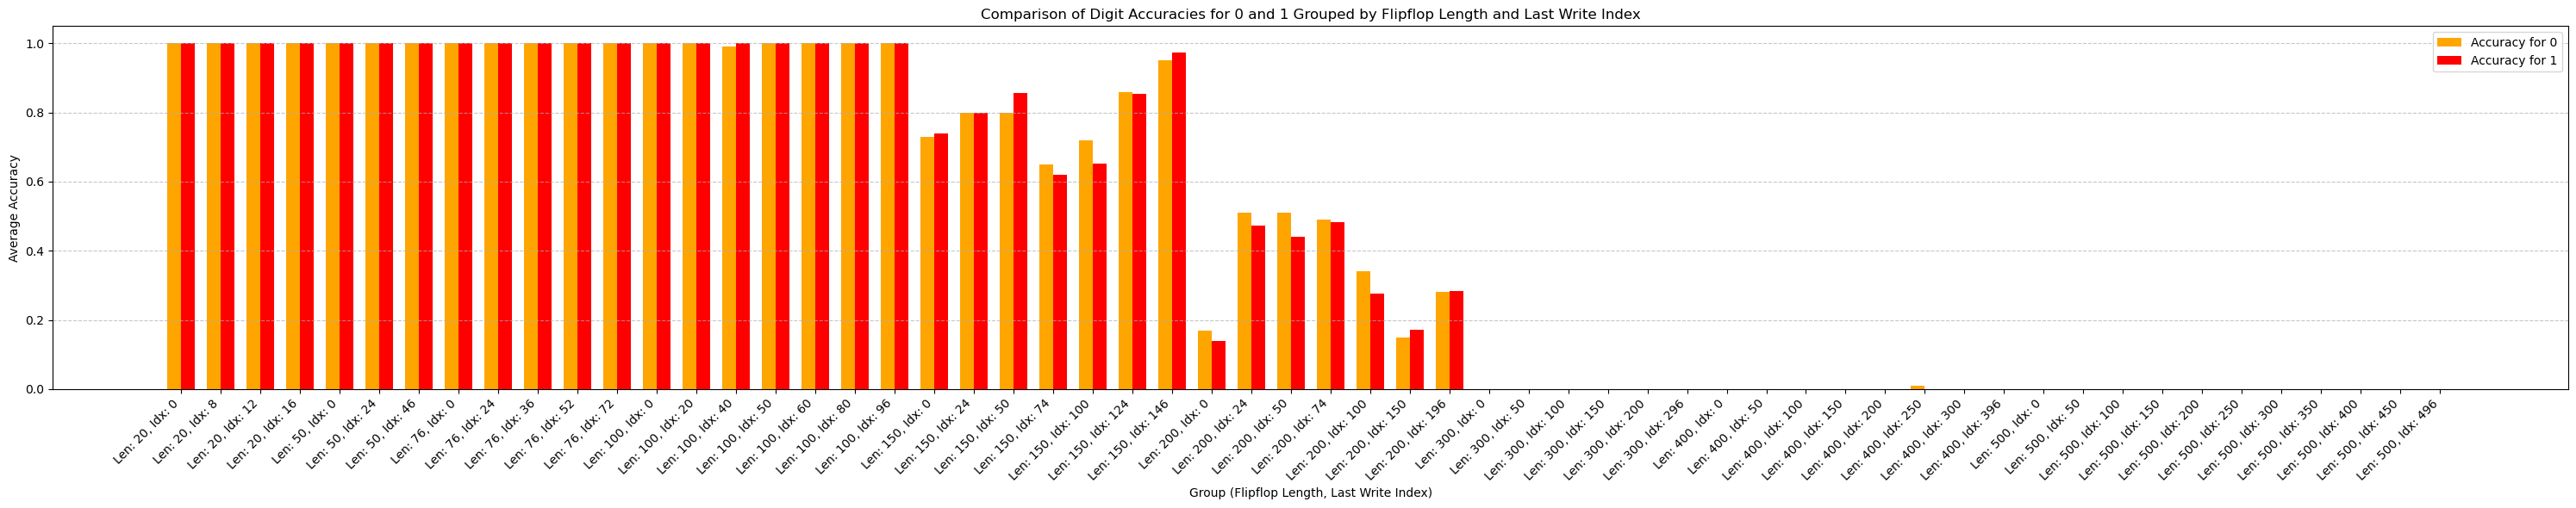

In [35]:
grouped_digit_accuracies_1 = defaultdict(list)

for result in all_data_llama:
    length = len(result[0]['flipflop'])
    dist = result[0]['last_write_index']
    acc = get_digit_accuracy(result, 1) 
    grouped_digit_accuracies_1[(length, dist)].append(acc)

# Aggregate and sort data
grouped_results_1 = {}
for (length, dist), accuracies in grouped_digit_accuracies_0.items():
    avg_acc = sum(accuracies) / len(accuracies)  # Average accuracy for the group
    grouped_results_1[(length, dist)] = avg_acc

# Sort by length and last_write_index
sorted_grouped_results_1 = dict(sorted(grouped_results_1.items(), key=lambda x: (x[0][0], x[0][1])))

# Display results
for (length, dist), avg_acc in sorted_grouped_results_1.items():
    print(f"Digit accuracy for flipflop with length {length} and last write idx {dist} is {avg_acc}")

x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted_grouped_results_0.keys()]
accuracies_0 = [sorted_grouped_results[k] for k in sorted_grouped_results_0.keys()]
accuracies_1 = [sorted_grouped_results_1[k] for k in sorted_grouped_results_1.keys()]

# Plot
bar_width = 0.35
indices = np.arange(len(x_labels))

plt.figure(figsize=(30, 6))
plt.bar(indices - bar_width / 2, accuracies_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, accuracies_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Group (Flipflop Length, Last Write Index)")
plt.ylabel("Average Accuracy")
plt.title("Comparison of Digit Accuracies for 0 and 1 Grouped by Flipflop Length and Last Write Index")
plt.xticks(indices, x_labels, rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Distance OLMo results

In [36]:
olmo_path = "OLMo_7B-instruct/distance/s1"

all_data_olmo = []

for file_name in os.listdir(olmo_path):
    if file_name.endswith(".jsonl"):
        file_path = os.path.join(olmo_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            one_sample_data = []
            for line in file:
                one_sample = json.loads(line)
                one_sample_data.append(one_sample)
            all_data_olmo.append(one_sample_data)

print(f"Loaded {len(all_data_olmo)} entries from {olmo_path}.")

# Assert everything loaded correctly
for result in all_data_olmo:
    length = len(result[0]['flipflop'])
    for response in result:
        assert len(response['flipflop']) == length


Loaded 58 entries from OLMo_7B/distance/s1.


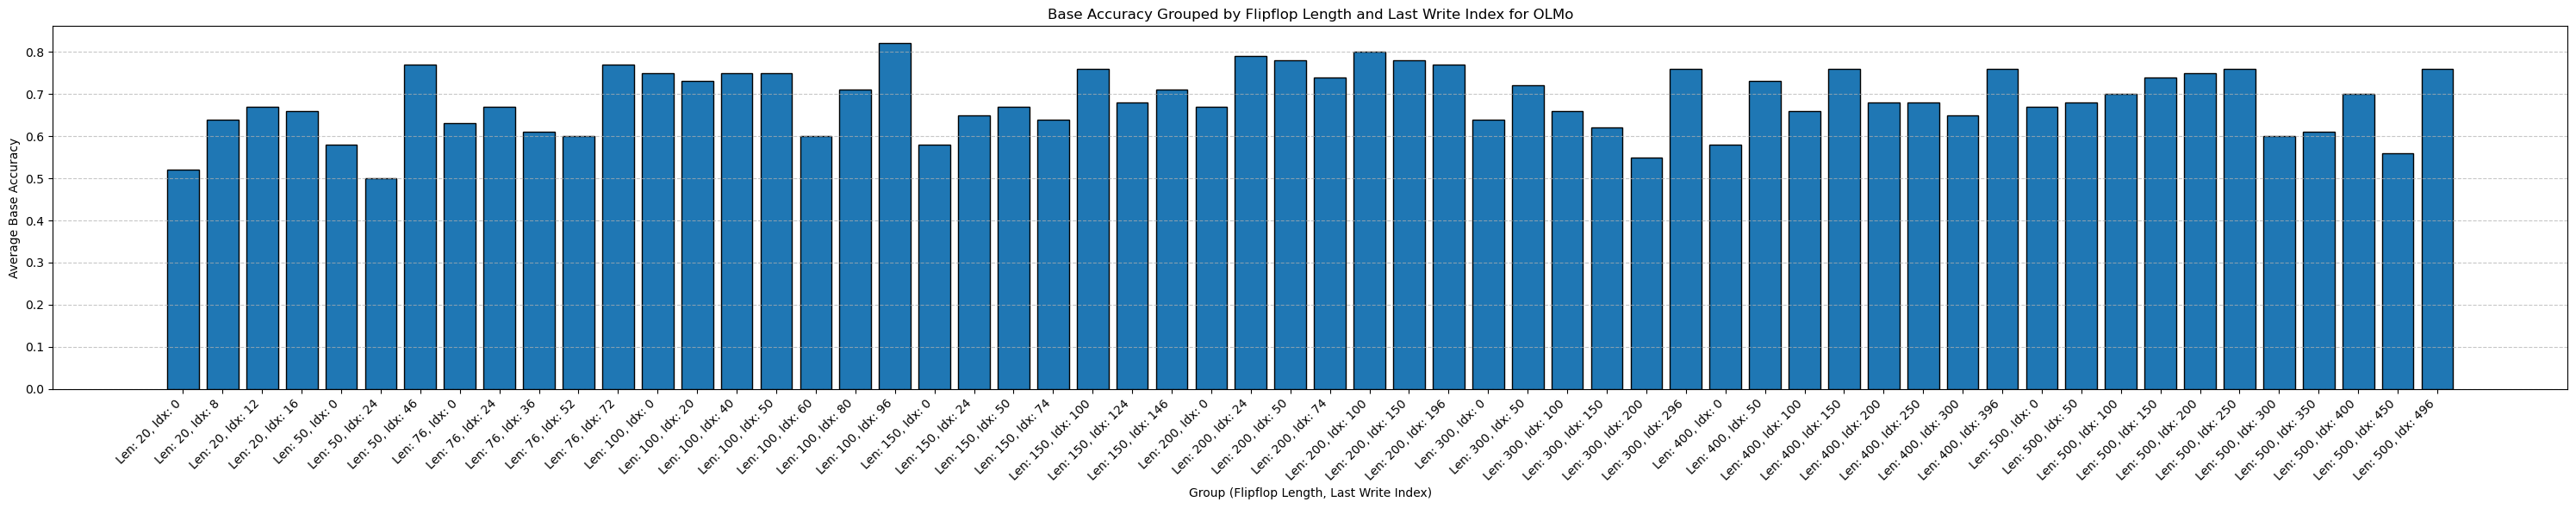

In [37]:
grouped_accuracies = defaultdict(list)

for result in all_data_olmo:
    acc = get_base_accuracy(result)
    length = len(result[0]['flipflop'])
    idx = result[0]['last_write_index']
    grouped_accuracies[(length, idx)].append(acc)

# Aggregate and sort data
grouped_results = {}
for (length, idx), accuracies in grouped_accuracies.items():
    avg_acc = sum(accuracies) / len(accuracies)  # Average accuracy for the group
    grouped_results[(length, idx)] = avg_acc

# Sort by length and last_write_index
sorted_grouped_results = dict(sorted(grouped_results.items(), key=lambda x: (x[0][0], x[0][1])))

# Prepare data for plotting
x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted_grouped_results.keys()]
accuracies = list(sorted_grouped_results.values())

# Plot
plt.figure(figsize=(30, 6))
plt.bar(x_labels, accuracies, width=0.8, align='center', edgecolor='black')
plt.xlabel("Group (Flipflop Length, Last Write Index)")
plt.ylabel("Average Base Accuracy")
plt.title("Base Accuracy Grouped by Flipflop Length and Last Write Index for OLMo")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [38]:
grouped_digit_accuracies_0 = defaultdict(list)

for result in all_data_olmo:
    length = len(result[0]['flipflop'])
    dist = result[0]['last_write_index']
    acc = get_digit_accuracy(result, 0)  # Replace 0 with desired digit if needed
    grouped_digit_accuracies_0[(length, dist)].append(acc)

# Aggregate and sort data
grouped_results_0 = {}
for (length, dist), accuracies in grouped_digit_accuracies_0.items():
    avg_acc = sum(accuracies) / len(accuracies)  # Average accuracy for the group
    grouped_results_0[(length, dist)] = avg_acc

# Sort by length and last_write_index
sorted_grouped_results_0 = dict(sorted(grouped_results_0.items(), key=lambda x: (x[0][0], x[0][1])))

# Display results
for (length, dist), avg_acc in sorted_grouped_results_0.items():
    print(f"Digit accuracy for flipflop with length {length} and last write idx {dist} is {avg_acc}")


Digit accuracy for flipflop with length 20 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 20 and last write idx 8 is 0.9811320754716981
Digit accuracy for flipflop with length 20 and last write idx 12 is 0.9777777777777777
Digit accuracy for flipflop with length 20 and last write idx 16 is 0.9615384615384616
Digit accuracy for flipflop with length 50 and last write idx 0 is 0.7708333333333334
Digit accuracy for flipflop with length 50 and last write idx 24 is 0.8
Digit accuracy for flipflop with length 50 and last write idx 46 is 0.8222222222222222
Digit accuracy for flipflop with length 76 and last write idx 0 is 0.5490196078431373
Digit accuracy for flipflop with length 76 and last write idx 24 is 0.68
Digit accuracy for flipflop with length 76 and last write idx 36 is 0.6037735849056604
Digit accuracy for flipflop with length 76 and last write idx 52 is 0.5714285714285714
Digit accuracy for flipflop with length 76 and last write idx 72 is 0.8125
Digit accuracy f

In [39]:
grouped_digit_accuracies_1 = defaultdict(list)

for result in all_data_olmo:
    length = len(result[0]['flipflop'])
    dist = result[0]['last_write_index']
    acc = get_digit_accuracy(result, 1) 
    grouped_digit_accuracies_1[(length, dist)].append(acc)

# Aggregate and sort data
grouped_results_1 = {}
for (length, dist), accuracies in grouped_digit_accuracies_0.items():
    avg_acc = sum(accuracies) / len(accuracies)  # Average accuracy for the group
    grouped_results_1[(length, dist)] = avg_acc

# Sort by length and last_write_index
sorted_grouped_results_1 = dict(sorted(grouped_results_1.items(), key=lambda x: (x[0][0], x[0][1])))

# Display results
for (length, dist), avg_acc in sorted_grouped_results_1.items():
    print(f"Digit accuracy for flipflop with length {length} and last write idx {dist} is {avg_acc}")


Digit accuracy for flipflop with length 20 and last write idx 0 is 1.0
Digit accuracy for flipflop with length 20 and last write idx 8 is 0.9811320754716981
Digit accuracy for flipflop with length 20 and last write idx 12 is 0.9777777777777777
Digit accuracy for flipflop with length 20 and last write idx 16 is 0.9615384615384616
Digit accuracy for flipflop with length 50 and last write idx 0 is 0.7708333333333334
Digit accuracy for flipflop with length 50 and last write idx 24 is 0.8
Digit accuracy for flipflop with length 50 and last write idx 46 is 0.8222222222222222
Digit accuracy for flipflop with length 76 and last write idx 0 is 0.5490196078431373
Digit accuracy for flipflop with length 76 and last write idx 24 is 0.68
Digit accuracy for flipflop with length 76 and last write idx 36 is 0.6037735849056604
Digit accuracy for flipflop with length 76 and last write idx 52 is 0.5714285714285714
Digit accuracy for flipflop with length 76 and last write idx 72 is 0.8125
Digit accuracy f

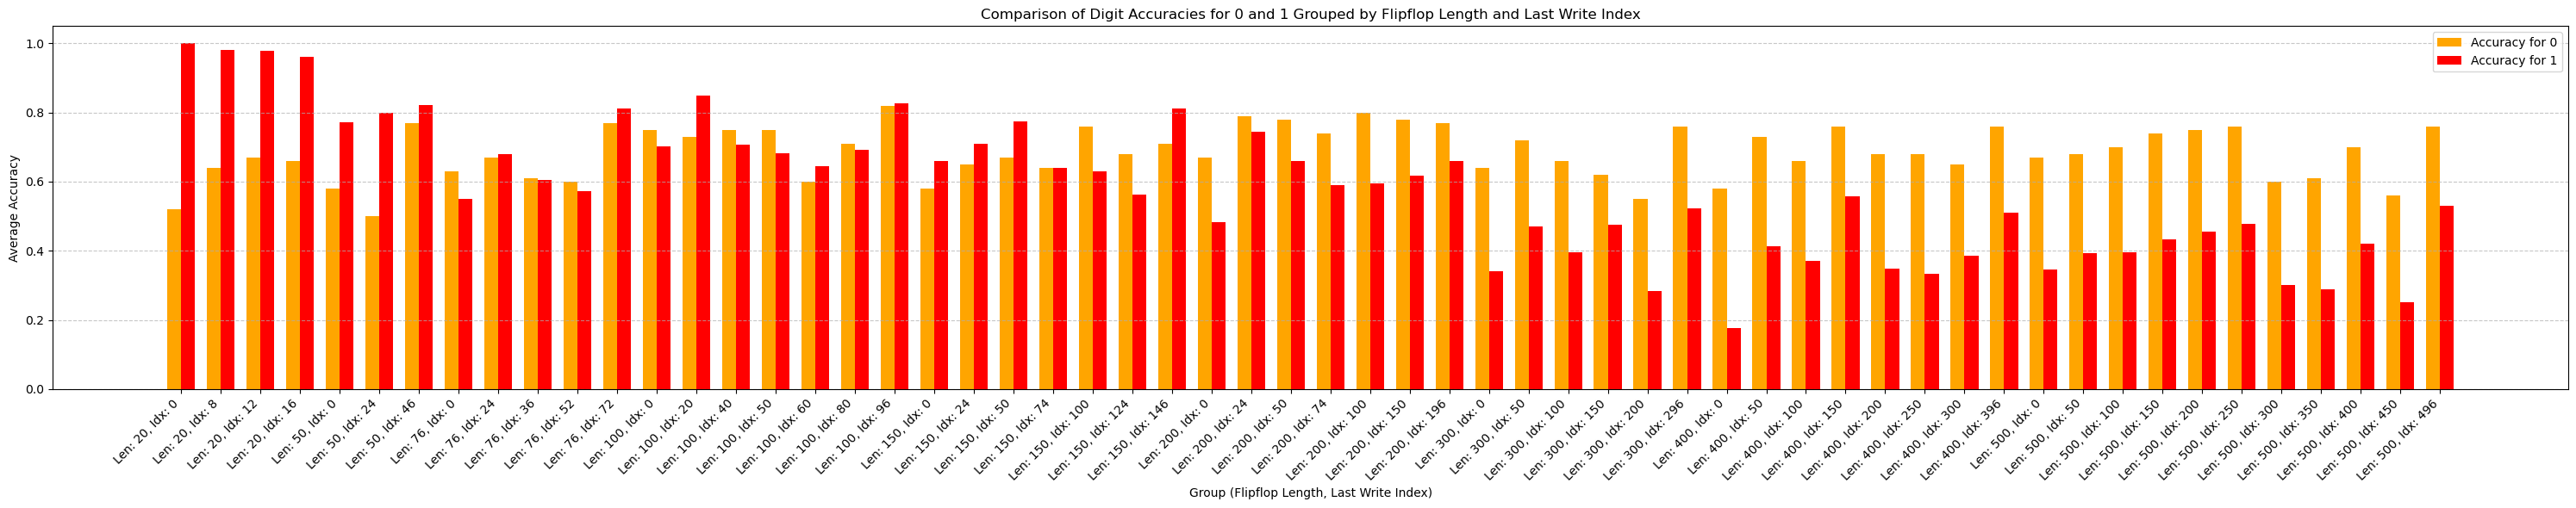

In [40]:
x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted_grouped_results_0.keys()]
accuracies_0 = [sorted_grouped_results[k] for k in sorted_grouped_results_0.keys()]
accuracies_1 = [sorted_grouped_results_1[k] for k in sorted_grouped_results_1.keys()]

# Plot
bar_width = 0.35
indices = np.arange(len(x_labels))

plt.figure(figsize=(30, 6))
plt.bar(indices - bar_width / 2, accuracies_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, accuracies_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Group (Flipflop Length, Last Write Index)")
plt.ylabel("Average Accuracy")
plt.title("Comparison of Digit Accuracies for 0 and 1 Grouped by Flipflop Length and Last Write Index")
plt.xticks(indices, x_labels, rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()